In [1]:
import vishack
import matplotlib.pyplot as plt
import numpy as np
import control
import kontrol

prefix = "../data/ham4/ham4_all_sensors_"
dates = ["20250203", "20250206", "20250209", "20250212", "20250215", "20250218", "20250221", "20250224", "20250227"]
suffix = ".xml"

data_list = []

for date in dates:
    filename = prefix + date + suffix
    data = vishack.data.diaggui.Diaggui(filename)
    data_list.append(data)

In [2]:
# data_list = [data1, data2, data3, data4, data5]
inert_channel = "L1:ISI-HAM4_BLND_GS13Y_IN1_DQ"
rel_channel = "L1:ISI-HAM4_BLND_CPSY_IN1_DQ"
coh_channel = "L1:ISI-GND_STS_ITMY_Y_DQ"

inert_list = []
inert_res_list = []
cps_list = []
cps_res_list = []
log_inert_list = []
# log_t240_list = []

s = control.tf("s")
seis_cal = 1/s*1e-9
wn = 1*2*np.pi
q = 1/np.sqrt(2)
inert_cal = (s**2 + wn/q*s + wn**2) / s**3 * 1e-9

for data in data_list:
    f, inert = data.psd(inert_channel)
    f, cps = data.psd(rel_channel)
    f, coh = data.coh(inert_channel, coh_channel)
#     f, cps_coh = data.coh("L1:ISI-HAM8_BLND_CPSY_IN1_DQ", "L1:ISI-HAM8_BLND_T240Y_IN1_DQ")
#     f, t240 = data.psd("L1:ISI-HAM8_BLND_T240Y_IN1_DQ")
    
    inert = inert[f>0]
    coh = coh[f>0]
#     t240 = t240[f>0]
#     cps_coh = cps_coh[f>0]
    inert = inert * abs(inert_cal(1j*2*np.pi*f))
#     cps = cps * 1e-9
#     t240 = t240 * abs(seis_cal(1j*2*np.pi*f))
    inert_res = (inert**2 * (1-coh**.5))**.5
#     cps_res = (cps**2 * (1-cps_coh**.5))**.5
    

    inert_list.append(inert)
    cps_list.append(cps)
    log_inert_list.append(np.log10(inert_res))
    inert_res_list.append(inert_res)
#     cps_res_list.append(cps_res)
#     log_t240_list.append(np.log10(t240))
    # log_res_list.append(np.log10(res))

inert_mean = 10**np.mean(log_inert_list, axis=0)
inert_std = np.std(log_inert_list, axis=0)
inert_sigma1 = 10**(np.log10(inert_mean) + inert_std)
inert_sigma2 = 10**(np.log10(inert_mean) + 2*inert_std)

# t240_mean = 10**np.mean(log_t240_list, axis=0)
# seis_mean = 10**np.mean(log_seis_list, axis=0)
# seis_std = np.std(log_seis_list, axis=0)
# seis_sigma1 = 10**(np.log10(seis_mean) + seis_std)
# seis_sigma2 = 10**(np.log10(seis_mean) + 2*seis_std)

# res_mean = 10**np.mean(log_res_list, axis=0)
# res_std = np.std(log_res_list, axis=0)
# res_sigma1 = 10**(np.log10(res_mean) + res_std)
# res_sigma2 = 10**(np.log10(res_mean) + 2*res_std)

# f = f[f>0]

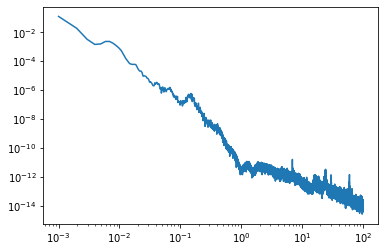

In [4]:
plt.loglog(f, inert_res_list[3])

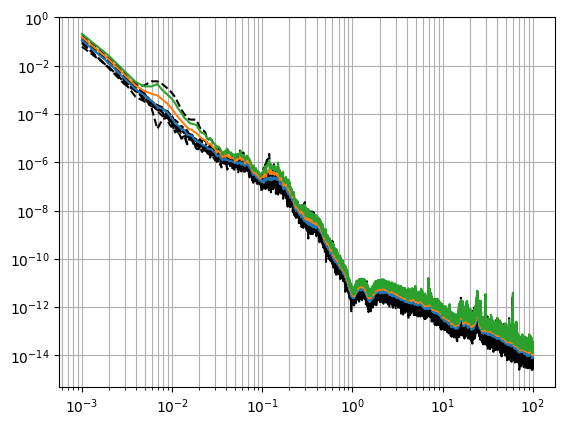

In [3]:
# for inert in inert_list:
#     plt.loglog(f, inert)

# for cps in cps_list:
#     plt.loglog(f, cps)

# for cps in cps_res_list:
#     plt.loglog(f, cps)

# plt.loglog(f, n_cps, "k")
for inert_res in inert_res_list:
    plt.loglog(f, inert_res, "k--")

plt.loglog(f, inert_mean)
plt.loglog(f, inert_sigma1)
plt.loglog(f, inert_sigma2)

# plt.loglog(f, t240_mean)

plt.grid(which="both")

In [7]:
def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]
n_cps = noise_model(f, *n_ade1_params)

In [23]:
# Get corrected CPS noise
seis_data = np.load("noise_spectrums/ham4/seismic_mean.npz")
seismometer_data = np.load("noise_spectrums/ham4/seismometer_mean.npz")
seis = seis_data["data"]
seismometer = seismometer_data["data"]

h_sc_mean = kontrol.load_transfer_function("sensor_correction_filters/ham4/h_sc_mean.pkl")
h_sc_prefilt = kontrol.load_transfer_function("sensor_correction_filters/ham4/prefilt.pkl")

h_sc_mean *= h_sc_prefilt

seis_filt = seis*abs(1-h_sc_mean(1j*2*np.pi*f))
seismometer_filt = seismometer * abs(h_sc_mean(1j*2*np.pi*f))
n_sc_mean = (seis_filt**2 + seismometer_filt**2)**.5
cps_mean = (n_cps**2 + n_sc_mean**2)**.5
# h_sc_sigma1


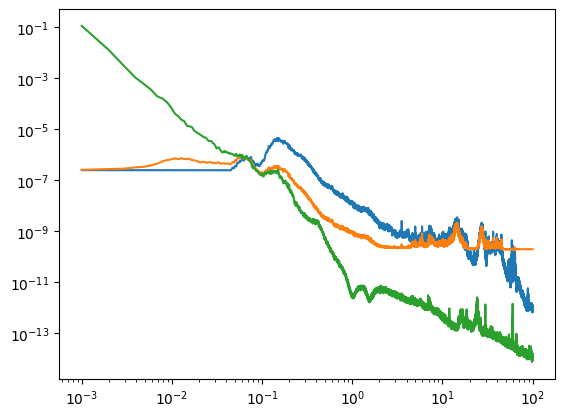

In [24]:
plt.loglog(f, seis)
plt.loglog(f, cps_mean)
plt.loglog(f, inert_mean)

In [25]:
import scipy

inert_interp = scipy.interpolate.interp1d(f, np.log10(inert_mean))
inert_sigma1_interp = scipy.interpolate.interp1d(f, np.log10(inert_sigma1))
inert_sigma2_interp = scipy.interpolate.interp1d(f, np.log10(inert_sigma2))
cps_interp = scipy.interpolate.interp1d(f, np.log10(cps_mean))

In [26]:
f_ = np.logspace(-3, 2, 1024)

In [27]:
inert_interp(f_)

array([ -0.95081875,  -0.96161926,  -0.97254201, ..., -13.89240306,
       -13.86114047, -13.94988998])

In [28]:
inert_data = 10**inert_interp(f_)
inert_sigma1_data = 10**inert_sigma1_interp(f_)
inert_sigma2_data = 10**inert_sigma2_interp(f_)
cps_data = 10**cps_interp(f_)

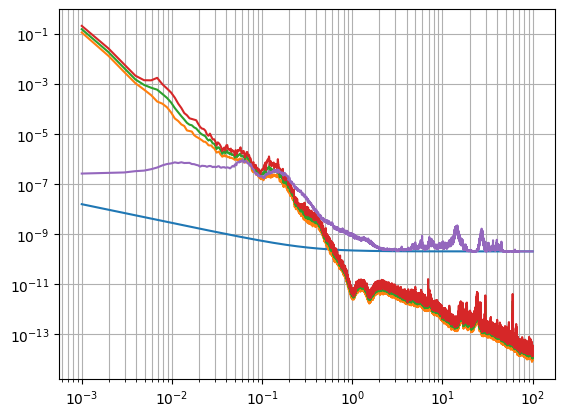

In [29]:
# plt.loglog(f, seismometer_filt)
# plt.loglog(f, seis_filt)
plt.loglog(f, n_cps)
plt.loglog(f, inert_mean)
plt.loglog(f, inert_sigma1)
plt.loglog(f, inert_sigma2)
# plt.loglog(f_, inert_data*abs(h2p(1j*2*np.pi*f_)))
# plt.loglog(f_, inert_pad)
# plt.loglog(f_, abs(inert_fit(1j*2*np.pi*f_)))
plt.loglog(f, cps_mean)
# plt.loglog(f_, cps_data*abs(h1p(1j*2*np.pi*f_)))
# plt.loglog(f_, abs(cps_fit(1j*2*np.pi*f_)))

# plt.loglog(f, inert_sigma1)
# plt.loglog(f_, inert_sigma1_data)
# plt.loglog(f_, abs(inert_sigma1_fit(1j*2*np.pi*f_)))

# plt.loglog(f_, inert_sigma2_data)
# plt.loglog(f_, abs(inert_sigma2_fit(1j*2*np.pi*f_)))

# plt.loglog(f, inert_sigma2)
plt.grid(which="both")

In [30]:
inert_pad = inert_data.copy()
inert_pad[f_<0.003] = inert_data[f_>0.003][0]
inert_pad[f_>20] = inert_data[f_<20][-1]

inert_sigma1_pad = inert_sigma1_data.copy()
inert_sigma1_pad[f_<0.003] = inert_sigma1_data[f_>0.003][0]
inert_sigma1_pad[f_>20] = inert_sigma1_data[f_<20][-1]

inert_sigma2_pad = inert_sigma2_data.copy()
inert_sigma2_pad[f_<0.003] = inert_sigma2_data[f_>0.003][0]
inert_sigma2_pad[f_>20] = inert_sigma2_data[f_<20][-1]

inert_mask = (f_<0.3) + (f_>2)
# sigma2_mask = (f_<0.08) + (f_>0.14)

In [31]:
inert_fit = kontrol.curvefit.spectrum_fit(f=f_[inert_mask], spectrum=inert_pad[inert_mask], nzero=8, npole=8)

In [44]:
inert_sigma1_fit = kontrol.curvefit.spectrum_fit(f=f_[inert_mask], spectrum=inert_sigma1_pad[inert_mask], nzero=8, npole=8, seed=2)

In [48]:
inert_sigma2_fit = kontrol.curvefit.spectrum_fit(f=f_[inert_mask], spectrum=inert_sigma2_pad[inert_mask], nzero=8, npole=8, seed=1)

In [34]:
cps_fit = kontrol.curvefit.spectrum_fit(f=f_, spectrum=cps_data, nzero=6, npole=6)

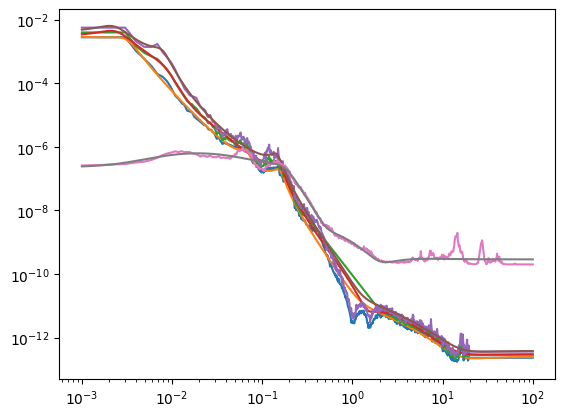

In [52]:
plt.loglog(f_, inert_pad)
plt.loglog(f_, abs(inert_fit(1j*2*np.pi*f_)))

plt.loglog(f_[inert_mask], inert_sigma1_pad[inert_mask])
plt.loglog(f_, abs(inert_sigma1_fit(1j*2*np.pi*f_)))

plt.loglog(f_, inert_sigma2_pad)
plt.loglog(f_, abs(inert_sigma2_fit(1j*2*np.pi*f_)))

plt.loglog(f_, cps_data)
plt.loglog(f_, abs(cps_fit(1j*2*np.pi*f_)))

In [287]:
f_ = np.logspace(-4, 2, 1024)

In [26]:
def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]
n_cps = noise_model(f, *n_ade1_params)

In [53]:
tf_weight = kontrol.load_transfer_function("suspension_models/hsts_weight.pkl")
s = control.tf("s")
weight = (s+(2*np.pi*10))/(s+(2*np.pi*1)) / 10

In [61]:
comp = kontrol.ComplementaryFilter()
comp.noise2 = cps_fit * tf_weight
comp.noise1 = inert_fit * tf_weight * weight
comp.weight2 = 1/inert_fit / weight
comp.weight1 = 1/cps_fit
h1, h2 = comp.h2synthesis()
h2, h1 = comp.hinfsynthesis()

In [65]:
comp_sigma1 = kontrol.ComplementaryFilter()
comp_sigma1.noise2 = cps_fit * tf_weight
comp_sigma1.noise1 = inert_sigma1_fit * tf_weight * weight
comp_sigma1.weight2 = 1/inert_sigma1_fit / weight
comp_sigma1.weight1 = 1/cps_fit
h1_sigma1, h2_sigma1 = comp_sigma1.h2synthesis()
h2_sigma1, h1_sigma1 = comp_sigma1.hinfsynthesis()

In [70]:
comp_sigma2 = kontrol.ComplementaryFilter()
comp_sigma2.noise1 = cps_fit * tf_weight
comp_sigma2.noise2 = inert_sigma2_fit * tf_weight * weight
comp_sigma2.weight1 = 1/inert_sigma2_fit / weight
comp_sigma2.weight2 = 1/cps_fit
h1_sigma2, h2_sigma2 = comp_sigma2.h2synthesis()
h1_sigma2, h2_sigma2 = comp_sigma2.hinfsynthesis()

In [71]:
prefilt = (s/(s+2*np.pi*0.003))**4
h2p = h2*prefilt
h1p = 1-h2p

h2p_sigma1 = h2_sigma1*prefilt
h1p_sigma1 = 1-h2p_sigma1

h2p_sigma2 = h2_sigma2*prefilt
h1p_sigma2 = 1-h2p_sigma2

In [58]:
ligo_h1 = kontrol.load_transfer_function("complementary_filters/102mHzv2_disp.pkl")
ligo_h2 = kontrol.load_transfer_function("complementary_filters/102mHzv2_inert.pkl")

ligo_h2 /= (s**2 + wn/q*s + wn**2) / s**3

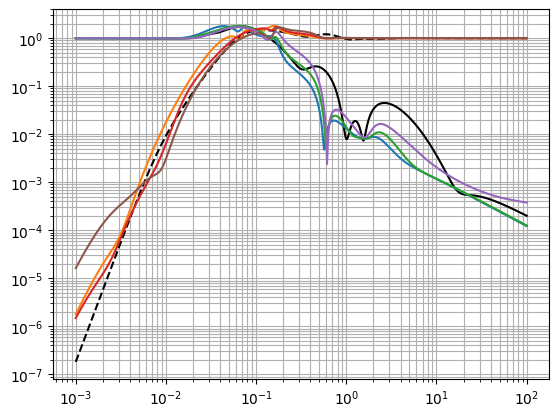

In [72]:
# plt.loglog(f_, abs(h1(1j*2*np.pi*f_)))
# plt.loglog(f_, abs(h2(1j*2*np.pi*f_)))
plt.loglog(f_, abs(ligo_h1(1j*2*np.pi*f_)), "k")
plt.loglog(f_, abs(ligo_h2(1j*2*np.pi*f_)), "k--")

plt.loglog(f, abs(h1p(1j*2*np.pi*f)))
plt.loglog(f_, abs(h2p(1j*2*np.pi*f_)))

plt.loglog(f_, abs(h1p_sigma1(1j*2*np.pi*f_)))
plt.loglog(f_, abs(h2p_sigma1(1j*2*np.pi*f_)))

plt.loglog(f_, abs(h1p_sigma2(1j*2*np.pi*f_)))
plt.loglog(f_, abs(h2p_sigma2(1j*2*np.pi*f_)))

plt.grid(which="both")

In [73]:
h1p

TransferFunction(array([1.11022302e-16, 7.70481908e-02, 1.68176090e+01, 1.66243284e+03,
       1.00304456e+05, 4.19987723e+06, 1.31111246e+08, 3.19455254e+09,
       6.28286301e+10, 1.02226072e+12, 1.39862641e+13, 1.62988819e+14,
       1.63028556e+15, 1.40732366e+16, 1.05204962e+17, 6.82097933e+17,
       3.84440263e+18, 1.88495213e+19, 8.04674778e+19, 2.98766633e+20,
       9.59626370e+20, 2.66047676e+21, 6.27830194e+21, 1.25143309e+22,
       2.07309892e+22, 2.79757346e+22, 3.15882905e+22, 2.87783376e+22,
       2.19946024e+22, 1.34595287e+22, 6.78069740e+21, 2.76533537e+21,
       9.04961335e+20, 2.35577137e+20, 4.66003348e+19, 6.66078767e+18,
       6.67338008e+17, 4.50092383e+16, 1.96514235e+15, 5.36197431e+13,
       8.74335866e+11, 7.76299273e+09, 2.88250038e+07]), array([1.00000000e+00, 2.16304129e+02, 2.09959819e+04, 1.23007540e+06,
       4.95957594e+07, 1.48919942e+09, 3.50535611e+10, 6.68686365e+11,
       1.05718912e+13, 1.40691071e+14, 1.59266838e+15, 1.54418699e+16,
   

In [75]:
#export

h1p = kontrol.TransferFunction(h1p)
h1p.save("complementary_filters/ham4/h1_mean.pkl")

h2 = kontrol.TransferFunction(h2)
h2.save("complementary_filters/ham4/h2_mean.pkl")

h1p_sigma1 = kontrol.TransferFunction(h1p_sigma1)
h1p_sigma1.save("complementary_filters/ham4/h1_sigma1.pkl")

h2_sigma1 = kontrol.TransferFunction(h2_sigma1)
h2_sigma1.save("complementary_filters/ham4/h2_sigma1.pkl")

h1p_sigma2 = kontrol.TransferFunction(h1p_sigma2)
h1p_sigma2.save("complementary_filters/ham4/h1_sigma2.pkl")

h2_sigma2 = kontrol.TransferFunction(h2_sigma2)
h2_sigma2.save("complementary_filters/ham4/h2_sigma2.pkl")

h2_prefilt = kontrol.TransferFunction(prefilt)
h2_prefilt.save("complementary_filters/ham4/h2_prefilt.pkl")

In [76]:
#export noise spectrums
np.savez("noise_spectrums/ham4/inert_mean.npz", f=f, data=inert_mean)
np.savez("noise_spectrums/ham4/inert_sigma1.npz", f=f, data=inert_sigma1)
np.savez("noise_spectrums/ham4/inert_sigma2.npz", f=f, data=inert_sigma2)

np.savez("noise_spectrums/ham4/cps.npz", f=f, data=n_cps)